# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [1]:
# Python Standard Library
# -----------------------
pass

In [2]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

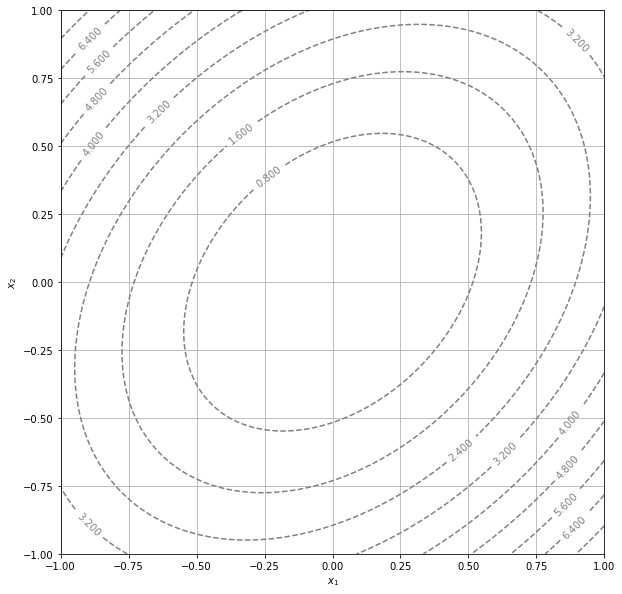

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [10]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

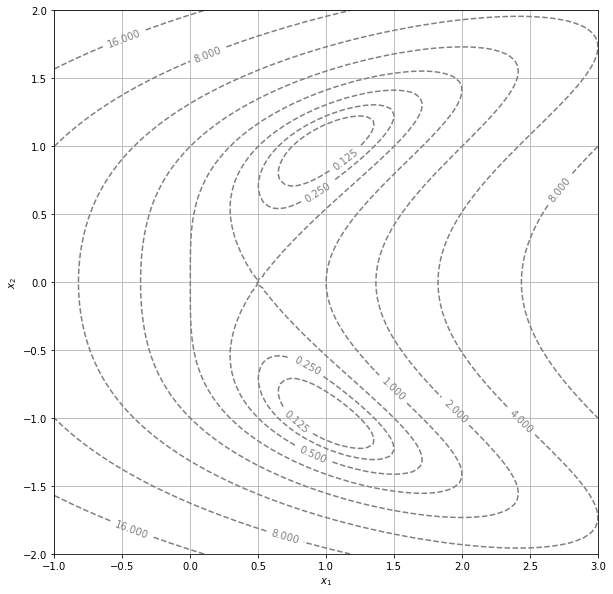

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

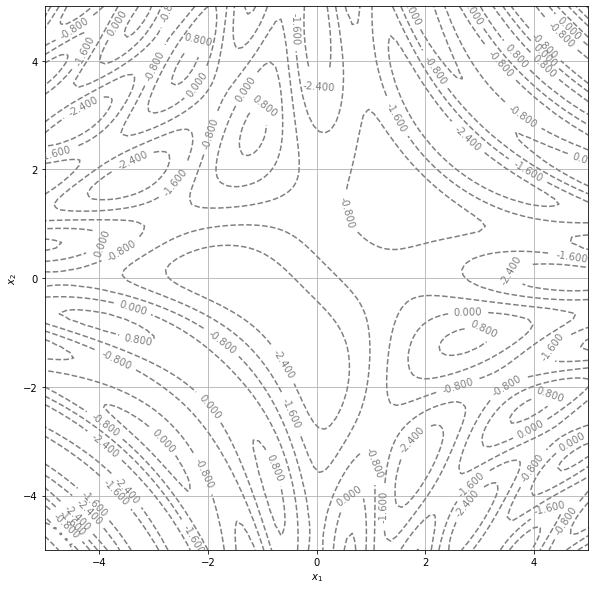

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

##### Réponse 1
Montrons que l'ensemble $E$ =  \{ $(x_1, x_2)$ | $f(x_1, x_2) = c$ }  est fermé borné.

##### Fermé :

On pose $g = f -c$

$g$ est continue car $f$ est continue, et on a : $E$ = $g^{-1}$(\{0})

Or {0} est fermé et $g$ est continue, donc $g^{-1}$(\{0}) l'est aussi.

Ainsi, $E$ est fermé.


##### Borné :

comme $f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$ , 

$\forall A \in \mathbb{R},  \exists (x_{10}, x_{20}),
\forall (x, y),
(||(x, y)|| > ||(x_{10}, x_{20})||
\Rightarrow |f(x, y)| > A)$

Pour $A = c$, soit donc $(x_1, y_1)$ tel que pour tout $(x, y)$ tel que $||(x, y)|| > ||(x_1, y_1)||$, on ait $|f(x, y)| > c$.

On a donc que tous les points de $E$ vérifient $||(x, y)|| < ||(x_1, y_1)||$.

Donc $E$ est borné car $E \subset B_F(0, ||(x_1, y_1)||)$.

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

##### Réponse 2

$p(x_1, x_2)$ correspond au produit vectoriel
$\left( \begin{array}{c}
x_1 - x_{10} \\
x_2 - x_{20}
\end{array} \right)$
avec $\frac { \nabla f(x_0)}{||\nabla f(x_0)||} $ et représente la projection de


$\left( \begin{array}{c}
x_1 \\
x_2
\end{array} \right)$
sur la tangente à la courbe représentative de f en $x_0$, qui est orthogonale à $\nabla f(x_0)$. C'est donc la distance de $(x_1, x_2)$ à la droite portée par $\nabla f(x_0)$.


#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

##### Réponse

On pose                

$\begin{array}{ccccc}
g & : & \mathbb{R}^2 \times \mathbb{R} & \to & \mathbb{R}^2 \\
 & & (x_1, x_2, t) & \mapsto & (f(x_1, x_2) - c,\ t - p(x_1, x_2)) \\
\end{array}$

On a : 
   $ g(x_1, x_2, t) = 0 \Leftrightarrow $ 
$\left
\{
\begin{array}{c}
f(x_1, x_2) = c\\ t = p(x_1, x_2)
\end{array}
\right.$

Calculons $\partial g_x(x_0, t_0)$ où $t_0 = p(x_0)$ est tel que $g(x_0, t_0) = 0$

$\partial g_x(x_0, t_0) = 
\begin{pmatrix}
\partial_1 f(x_0) & \partial_2 f(x_0) \\ -\partial_1 p(x_0) & -\partial_2 p(x_0)
\end{pmatrix} = 
\begin{pmatrix}
   \partial_1 f(x_0) & \partial_2 f(x_0) \\
   -\frac{\partial_2 f(x_0)}{||\nabla f(x_0)||}& -\frac{\partial_1 f(x_0)}{||\nabla f(x_0)||}
\end{pmatrix}$

On calcule $det \partial g_x(x_0, t_0) = \frac{\partial_1^2 f(x_0) + \partial_2^2 f(x_0)}{||\nabla f(x_0)||} = ||\nabla f(x_0)|| \ne 0$.

Donc $\partial g_x(x_0, t_0)$ est inversible. 

D'après le théorème des fonctions implicites, il existe donc un voisinage de 0, noté $]-\varepsilon, \varepsilon[$, et une fonction
\begin{equation}
\gamma:
\left|
  \begin{array}{rcl}
    ]-\varepsilon, \varepsilon[ \to \mathbb{R}^2 \\
    t \longmapsto \gamma(t) \\
  \end{array}
\right.
\end{equation}
continuement différentiable et telle que $\gamma(t) = (x_1, x_2)$

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

##### Réponse 4

On a : $(𝑥1, 𝑥2) = 𝛾(𝑡)$ et $𝑡 = 𝑝(𝑥1, 𝑥2)$ donc $(𝑥1, 𝑥2) = 𝛾(𝑝(𝑥1, 𝑥2))$. 

Ainsi, $𝛾\circ 𝑝$ est égale à l'identité sur un voisinage de (𝑥1, 𝑥2) dont $]−𝜀,𝜀[$ est l'image par $𝛾$, donc 𝛾 est inversible sur $]−𝜀,𝜀[$. 

On a donc que la dérivée $𝛾′(𝑡)$ ne s'annule pas sur $]−𝜀,𝜀[$.

Puis on calcule $\nabla f(\gamma(t))\bullet \gamma'(t)$

Comme $f(\gamma(t)) = c$, on a en dérivant par rapport à $t$ que $\nabla f(\gamma(t))\bullet \gamma'(t) = 0$

Donc les deux vecteurs sont bien orthogonaux. 




## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

##### Réponse 5
Un ordre de grandeur de l'epsilon machine serait trop petit (demande trop précise)
Vu les valeurs des courbes de niveau étudiées (précision d'environ $10^{-2}$), on peut se restreindre à $\varepsilon = 10^{-3}$

In [14]:
N = 100
eps = 0.001

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [15]:
c = 0.8  # on définit la valeur de c au début.

def Newton(F, x0, y0, N=100, eps=eps):
    x0, y0 = float(x0), float(y0) # on s'assure que les valeurs sont des flottants
    X0 = np.array([x0, y0])
    X = X0
    Jacob = J(F)    
    J_inv = np.linalg.inv(Jacob(x0, y0))
    for i in range(N):
        X = X - np.dot(J_inv, F(x0, y0))
        x = X[0]
        y = X[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps :
            return x, y
        x0, y0 = x, y
    else :
        raise ValueError(f"no convergence in {N} steps")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

##### Réponse tâche 2
On a besoin de fonctions $F$ de $\mathbb{R}^2$ dans $\mathbb{R}^2$ pour être compatible avec notre algorithme de Newton. Il faut donc rajouter une contraine supplémentaire sur $f$ qui soit réalisée lorsque $F(x, y) = 0$

In [16]:
# On crée une fonction de R2 dans R2 compatible avec Nexton et correspondant à f1 de l'énoncé, avec la condition supplémentaire que x=y
def F1(x, y):     
    return np.array([f1(x, y)-c, x - y])

# autre fonction de R2 dans R2 dont la contrainte supplémentaire est : x=12y
def G1(x, y):
    return np.array([f1(x, y) - c, x - 12 * y]) 



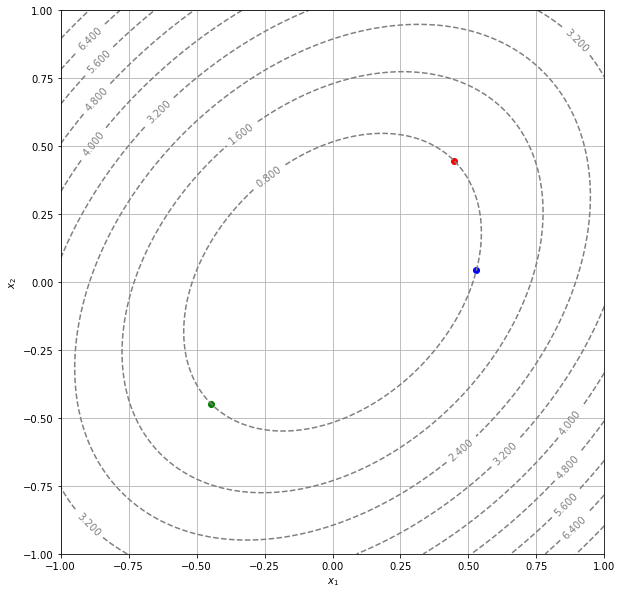

In [17]:
x1, y1 = Newton(F1, 0.8, 0.8) # point avec (x0, y0) = (0.8, 0.8) et la contrainte x=y
x2, y2 = Newton(G1, 0.8, 0.8) # point avec (x0, y0) = (0.8, 0.8) et la contrainte x= 12y
x3, y3 = Newton(F1, -0.5, -0.5) # point avec (x0, y0) = (0.5, 0.5) et la contrainte x=y

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
plt.scatter(x1, y1, c = 'red')
plt.scatter(x2, y2, c = 'blue')
plt.scatter(x3, y3, c = 'green')
plt.show()

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

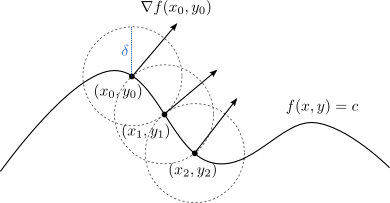

In [18]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
    c = f(x0, y0)
    # désormais la valeur de la courbe de niveau est donnée par f(x0, y0)
    
    # La fonction F de R2 dans R2 associée à la courbe de niveau c de f avec la condition que la distance à (x0, y0) soit égale à delta
    def F(x, y): 
        return np.array([f(x, y)-c, np.sqrt((x-x0)**2 + (y-y0)**2) - delta]) 
    
    x0, y0 = float(x0), float(y0)
    gradf = grad(f)
    Liste_points = [[x0, y0]] # la liste des points trouvés par la méthode de Newton
    x, y = x0, y0
    
    for i in range(N-1):
        x0, y0 = x, y 
        # il faut que la valeur de x0, y0 change à chaque boucle pour qu'on calcule la distance delta à partir du dernier point calculé
        
        norm_grad = np.linalg.norm(gradf(x, y)) 
        # norme du gradient en (x, y)
        
        rot_gradf = np.array([gradf(x, y)[1], - gradf(x, y)[0]]) 
        # on fait pivoter le gradient de 90° vers la droite
        
        decalage = delta/norm_grad * rot_gradf 
        # on crée un vecteur déclalage pour translater le point (x0, y0)
        x_int, y_int = x + decalage[0], y + decalage[1]
        x, y = Newton(F, x_int, y_int, N)
        Liste_points.append([x, y])
    
    Liste = np.array(Liste_points)
    L = Liste.transpose()
    # En transposant le tableau de taille, (N, 2), on se retrouve avec un tableau de taille (2, N) contenant les abscisses et les ordonnées. 
                
    return L

In [19]:
# On teste si l'algorithme marche
level_curve(f1, -0.375, 0.25)


array([[-0.375     , -0.30741178, -0.23197875, ...,  0.46383198,
         0.516039  ,  0.54231726],
       [ 0.25      ,  0.32370262,  0.38935402, ...,  0.4273546 ,
         0.34206373,  0.24558276]])

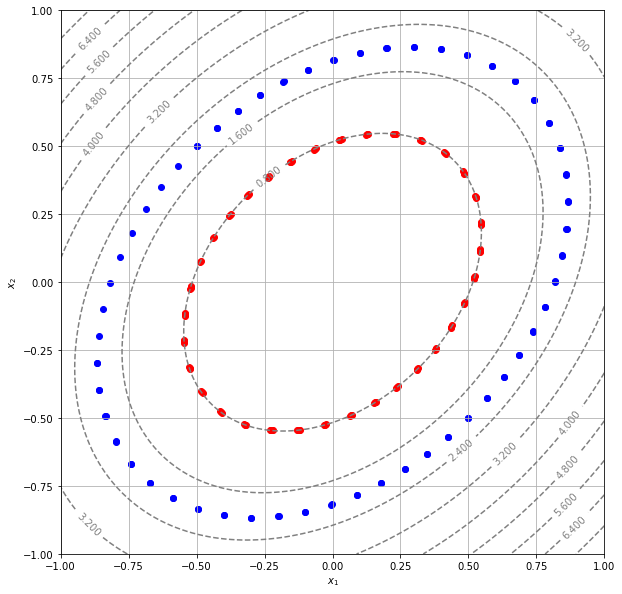

In [20]:
# Puis on code un nouveau graphe pour afficher les courbes de niveaux 
# et les points trouvés par l'algorithme précédent :

X1= level_curve(f1, -0.375, 0.25, 0.1, 100)[0] # on a choisi (x0, y0) à peu près sur la courbe de niveau 0,8
Y1= level_curve(f1, -0.375, 0.25, 0.1, 100)[1] # et on réduit N pour éviter que les points se superposent trop
X2= level_curve(f1, -0.5, 0.5, 0.1, 100)[0] 
Y2= level_curve(f1, -0.5, 0.5, 0.1, 100)[1]

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)
 
plt.scatter(X1, Y1, c = 'red')
plt.scatter(X2, Y2, c = 'blue')
plt.show()


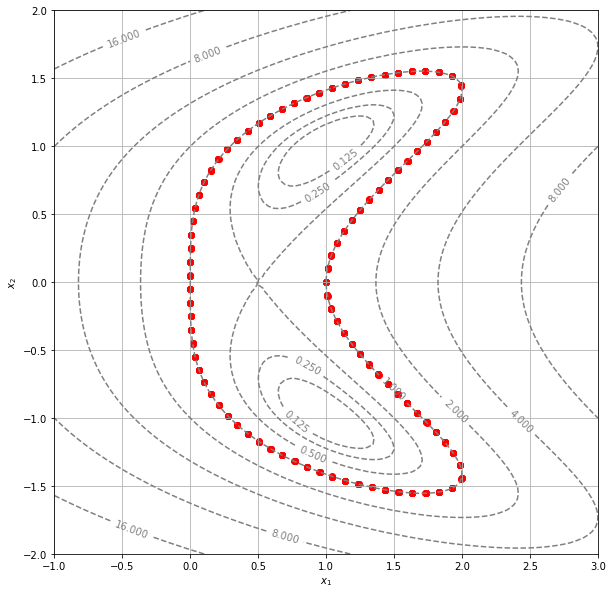

In [21]:
# pour la fonction f2
    
X1 = level_curve(f2, 1, 0, 0.1, 500)[0]
Y1 = level_curve(f2, 1, 0, 0.1, 500)[1]

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
plt.scatter(X1, Y1, c ='red')
plt.show()

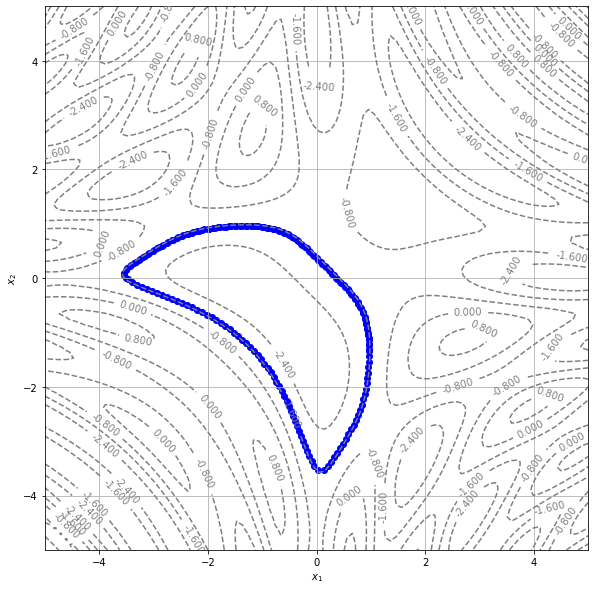

In [22]:
# et enfin f3

X3 = level_curve(f3, -3.5, 0, 0.1, 200)[0]
Y3 = level_curve(f3, -3.5, 0, 0.1, 200)[1]
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

plt.scatter(X3, Y3, c='blue')
plt.show()

#### Remarque :
Si N est trop grand, on fait le tour de la courbe de niveau plusieurs fois et les points se superposent.

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

##### Réponse 7

Il suffit de vérifier que le premier segment n'intersecte pas le dernier, car à ce moment là on aura fait le tour de la courbe de niveau.

Cela risque de ne pas fonctionner sur la courbe de Rosenbrock, mais ce genre de fonction est rare, car si cela arrive c'est généralement pour une seule courbe de niveau de la focntion.

In [23]:
# on crée une fonction qui vérifie si deux segments ont une intersection

def intersect(x1, y1, x2, y2, x3, y3, x4, y4): # les points 1 et 2 sont les extrémités du premier segment, 3 et 4 celles du 2ème.
    
    inter = False # ce booléen restera False si on ne trouve pas d'intersection
    
    if x1 != x2 and x3 != x4 : # cas de doites y = ax + b avec éventuellement a = 0
        
        a1 = (y2 - y1)/(x2 - x1) # coefficient directeur de la 1ère droite 
        a2 = (y4 - y3)/(x4 - x3)
    
        b1 = y1 - a1*x1  # ordonnée à l'origine de la première droite
        b2 = y3 - a2*x3
        
        if a1 != a2 :
            # coordonnées du point d'intersection des droites
            x = (b2 - b1)/(a1 - a2)
            y = a1*x + b1
            inter = True
           
            
    elif x1 == x2 and x3 != x4 : # avec une des droite de la forme x=c
        c = x1
        a2 = (y4 - y3)/(x4 - x3)
        b2 = y3 - a2 * x3
        
        x = c
        y = a2 * x + b2
        inter = True
    
    elif x3 == x4 and x1 != x2 : # avec l'autre droite de la forme x=c
        c = x3
        a1 = (y2 - y1)/(x2 - x1) 
        b1 = y1 - a1*x1
        
        x = c
        y = a1*x + b1
        inter = True
        
    # ensuite on va vérifier que le point d'intersection des droites est sur les segments.
    
    if inter == False :# on vérifie que le point d'intersection existe
        return False
    
    else : 
        if (x1 <= x <= x2 or x2 <= x <= x1) and (x3 <= x <= x4 or x4 <= x <= x3): 
        # abscisse du point compris entre celles des extrémités des 2 segments
            return True
        else : 
            return False 
    

In [24]:
# On teste si la fonction marche sur des exemples

intersect(0, 0, 3, 2, 0, 1, 3, 1)

True

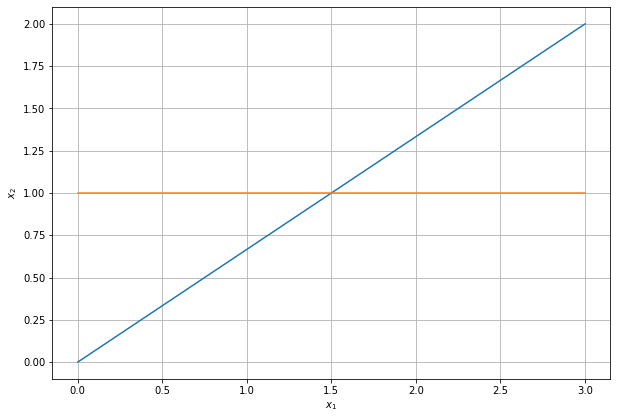

In [25]:
# illustration:

plt.grid(True)
plt.xlabel("$x_1$") 
plt.ylabel("$x_2$")
plt.gca().set_aspect("equal")

abs1 = [0, 3] 
abs2 = [0, 3]
ord1 = [0, 2] 
ord2 = [1, 1]

plt.plot(abs1, ord1)
plt.plot(abs2, ord2)
plt.show()

In [26]:
# deuxième exemple
intersect(0, 0, 2, 2, 6, 0, 6, 5)

False

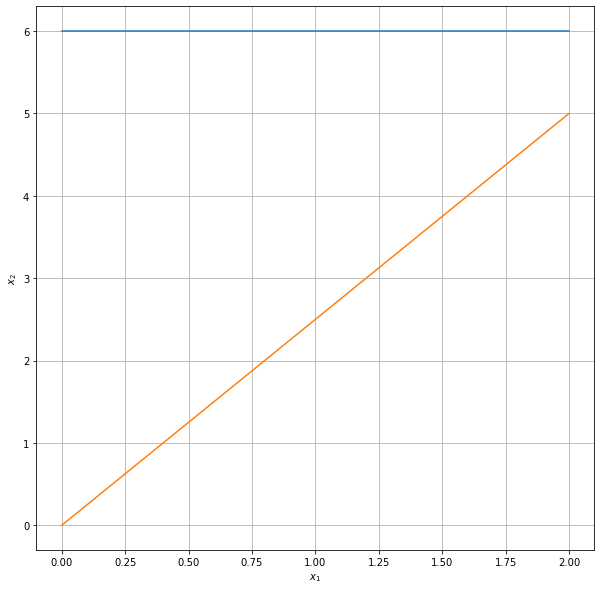

In [27]:
# illustration

plt.grid(True)
plt.xlabel("$x_1$") 
plt.ylabel("$x_2$")

abs1 = [0, 2] 
abs2 = [0, 2]
ord1 = [6, 6] 
ord2 = [0, 5]

plt.plot(abs1, ord1)
plt.plot(abs2, ord2)
plt.show()

In [28]:
# nouvelle fonction avec l'intersection comme condition d'arrêt

def level_curve2(f, x0, y0, delta=0.1, N=1000, eps=eps):
    c = f(x0, y0)
    def F(x, y): 
# La fonction F de R2 dans R2 associée à la courbe de niveau c de f 
# avec la condition que la distance à (x0, y0) soit égale à delta
        return np.array([f(x, y) - c, np.sqrt((x - x0)**2 + (y - y0)**2) - delta]) 
    
    x0, y0 = float(x0), float(y0)
    gradf = grad(f)
    norm_grad = np.linalg.norm(gradf(x0, y0))
    Liste_points = [[x0, y0]] # la liste des points trouvés parla méthode de Newton
    x, y = x0, y0
    x_0, y_0 = x0, y0 # on stocke les valeurs initiales car on en a besoin dans la boucle pour l'intersection
    
    # On trouve les 3 premiers points issus de la méthode de Newton d'abord 
    # car les 2 premiers segements ont une extrémité en commun, il faut donc traiter ce cas à part.
    
    for i in range(3):
        x0, y0 = x, y
        norm_grad = np.linalg.norm(gradf(x, y))
        rot_gradf = np.array([gradf(x, y)[1], -gradf(x, y)[0]]) # On fait tourner le gradient en (x, y) de 90° vers la droite
        decalage = delta/norm_grad * rot_gradf 
        x_int, y_int = x + decalage[0], y + decalage[1] # On décale le point initial vers la droite
        
        # Ainsi, le point le plus proche trouvé par la méthode de Newton sera bien le point à droite de (x0, y0)
    
        x, y = Newton(F, x_int, y_int, N)
        Liste_points.append([x, y])
    
    x1, y1 = Liste_points[1][0], Liste_points[1][1] 
    x_n1, y_n1 = Liste_points[-2][0], Liste_points[-2][1] # l'avant dernier point calculé
    x, y = Liste_points[-1][0], Liste_points[-1][1] # le dernier point calculé
    
    while intersect(x_0, y_0, x1, y1, x_n1, y_n1,  x, y) == False :
        x0, y0 = x, y
        # On réinitialise le point de référence pour que désormais on calcule le prochain point 
        # à distance delta du point trouvé précédemment.
        
        norm_grad = np.linalg.norm(gradf(x, y))
        rot_gradf = np.array([gradf(x, y)[1], -gradf(x, y)[0]])
        decalage = delta/norm_grad * rot_gradf 
        x_int, y_int = x + decalage[0], y + decalage[1]
        x_n1, y_n1 = x, y
        x, y, = Newton(F, x_int, y_int, N)
        Liste_points.append([x, y])
        
    
    Liste = np.array(Liste_points) # on transforme la liste en array
    L = Liste.T  
    
    return L

In [29]:
level_curve2(f1, 0.5, 0.4)

# on vérifie que la fonction marche et renvoie un tableau de taille (2, N) 
# dont la première liste est celle des abscisses et la deuxième celle des ordonnées.

array([[ 0.5       ,  0.5410046 ,  0.55730368,  0.55237164,  0.53010841,
         0.49370944,  0.44555852,  0.38739463,  0.32049648,  0.24583262,
         0.16418501,  0.07627088, -0.01709792, -0.11475077, -0.21467199,
        -0.3131573 , -0.4038264 , -0.47805201, -0.52866221, -0.55390339,
        -0.55644774, -0.54025632, -0.50883227, -0.46484944, -0.41026541,
        -0.34651175, -0.27465772, -0.19554148, -0.10988894, -0.01845314,
         0.07777151,  0.17716339,  0.27677318,  0.37130529,  0.45272639,
         0.5127118 ],
       [ 0.4       ,  0.3087927 ,  0.21013111,  0.110251  ,  0.01275863,
        -0.08038354, -0.16802926, -0.24937547, -0.3237049 , -0.39022959,
        -0.44796967, -0.49562894, -0.5314431 , -0.55299405, -0.55704773,
        -0.53969117, -0.49751701, -0.43050654, -0.34425856, -0.24750032,
        -0.1475315 , -0.04884888,  0.04608744,  0.13589732,  0.21968777,
         0.29673128,  0.36628143,  0.42744399,  0.47905716,  0.51955214,
         0.54677865,  0.55781

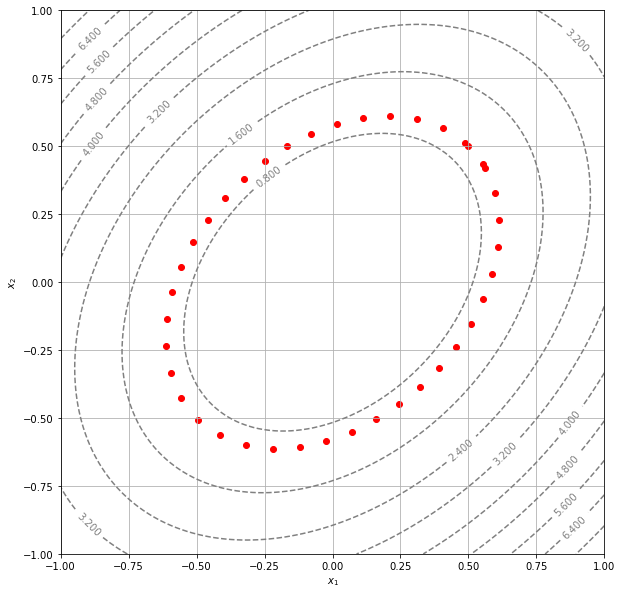

In [30]:
# Puis on code un nouveau graphe pour afficher les courbes de niveaux 
# et les points trouvés par l'algorithme précédent :

X1 = level_curve2(f1, 0.5, 0.5)[0] 
Y1 = level_curve2(f1, 0.5, 0.5)[1]

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected)
)

plt.scatter(X1, Y1, c='red')
plt.show()

# On voit que l'algorithme s'arrête au bout d'un tour.

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

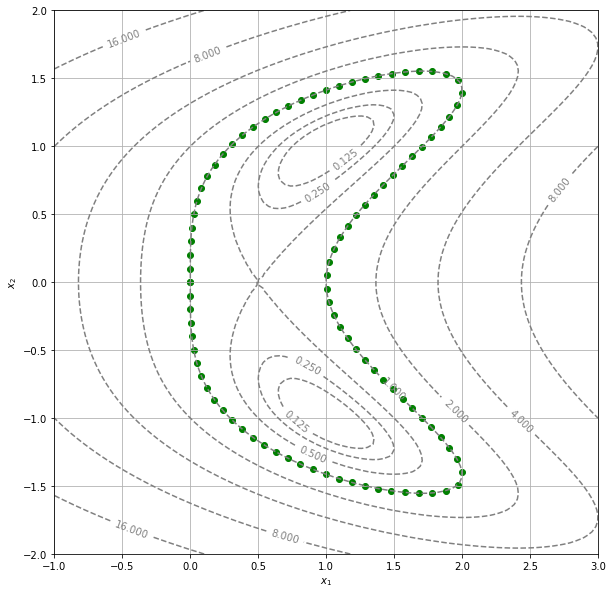

In [31]:
X1 = level_curve2(f2, 0, 0)[0] 
Y1 = level_curve2(f2, 0, 0)[1]

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

plt.scatter(X1, Y1, c='green')
plt.show()

### Observation :
En revanche, lorsqu'on essaie avec des points qui se situent sur la courbe de niveau de f2 qui se croise (c = 0.5), un message d'erreur s'affiche. 
Voir les cellules à la fin du devoir.

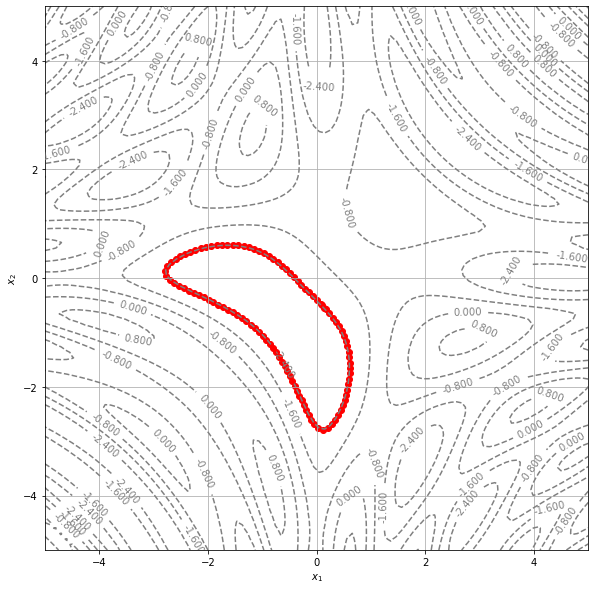

In [32]:
# pour la fonction f3:

X1 = level_curve2(f3, 0.1, -0.5)[0]
Y1 = level_curve2(f3, 0.1, -0.5)[1]

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

plt.scatter(X1, Y1, c='red')
plt.show()

On a essayé à chaque fois de choisir des points initiaux qui se situent sur des courbes de niveau intéressantes.

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

##### Réponse 8
Si on pose $P_1 = (x_1,y_1)$, $P_2 = (x_2,y_2)$, $u_1 = (a_1,b_1)$, $u_2 = (a_2,b_2)$

Sachant que $𝛾(0)=P_1$ et $𝛾(1)=P_2$, on a donc $a=x_1$ et $d=y_1$ puis on a le système:
$\left
\{
\begin{array}{c}
a+b+c=x_2\\d+e+f=y_2
\end{array}
\right.$

De plus, sachant que $𝛾'(0)=u_1$ et $𝛾'(1)=u_2$, on a :
$\left
\{
\begin{array}{c}
b=a_1\\e=b_1\\b+2c=a_2\\e+2f=b_2
\end{array}
\right.$
    
Donc en résolvant et en combinant les 2 systèmes, on a
$\left
\{
\begin{array}{c}
a=x_1\\b=2x_2-2x_1-a_2\\c=a_2-x_2+x_1\\d=y_1\\e=2y_2-2y_1-b_2\\f=b_2-y_2+y_1
\end{array}
\right.$

Pour qu'une telle fonction existe, il faut que $u_1$ et $u_2$ ne soient pas parallèles afin de pouvoir avoir une solution polynomiale comme le préconise l'énoncé.

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [33]:
# 1ère fonction pas vectorisée

def gamma(t, P1, P2, u1, u2):
    u1, u2 = np.array(u1), np.array(u2) # on vectorise u1 et u2 si ce n'est pas déjà fait
    x1, y1 = P1[0], P1[1]
    x2, y2 = P2[0], P2[1]
    a1, b1 = u1[0], u1[1]
    a2, b2 = u2[0], u2[1]
    if np.cross(u1, u2) != 0:
        a = x1
        b = 2*x2-2*x1-a2
        c = a2-x2+x1
        d = y1
        e = 2*y2-2*y1-b2
        f = b2-y2+y1
        return (a + b*t + c*t**2, d + e*t + f*t**2)
    else:
        return (x1*(1-t)+x2*t, y1*(1-t)+y2*t)

#2ème fonction vectorisée, dans laquelle on ne peut pas utiliser la fonction np.vectorize car gamma a plusieurs arguments.
# Nous n'avons pas su comment faire sans boucle for

def gamma_vectorized(T, P1, P2, u1, u2):
    Liste_points = []
    for t in T:
        Liste_points.append(gamma(t, P1, P2, u1, u2)) 
    L = np.array(Liste_points)
    return L.transpose() # pour avoir un tableau (2, len(gamma(T)))

In [34]:
gamma(0.5, (0, 0), (1, 1), [3, 4], [3, 4])

(0.5, 0.5)

In [35]:
# vérification
gamma_vectorized([0.2, 0.4, 0.6, 0.8], (0, 0), (1, 1), [3, 4], [3, 4])

array([[0.2, 0.4, 0.6, 0.8],
       [0.2, 0.4, 0.6, 0.8]])

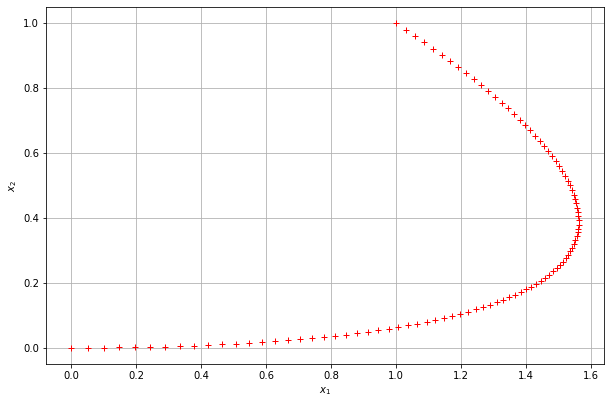

In [36]:
# en prenant des vecteurs et des point au hasard :

T = np.linspace(0, 1, 100) # on choisit 100 points entre 0 et 1
Y = gamma_vectorized(T, (0, 0), (1, 1), [3, 4], [-3, 2])

plt.grid(True)
plt.xlabel("$x_1$") 
plt.ylabel("$x_2$")
plt.gca().set_aspect("equal")
plt.plot(Y[0], Y[1], 'r+')
plt.show()

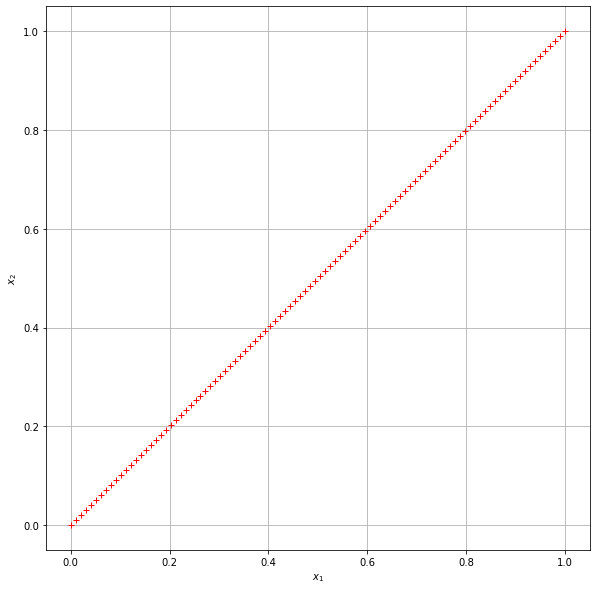

In [37]:
T = np.linspace(0, 1, 100) 
Y = gamma_vectorized(T, (0, 0), (1, 1), [3, 4], [3, 4]) # ici u1 et u2 sont colinéaires

plt.grid(True)
plt.xlabel("$x_1$") 
plt.ylabel("$x_2$")
plt.gca().set_aspect("equal")
plt.plot(Y[0], Y[1], 'r+')
plt.show()

# on obtient bien une droite. 

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [38]:
def level_curve3(f, x0, y0, oversampling, delta=0.1, N=1000, eps=eps):
    
    # même code initial que pour level_curve2
    
    c = f(x0, y0)
    def F(x, y): 
        return np.array([f(x, y) - c, np.sqrt((x - x0)**2 + (y - y0)**2) - delta]) 
    
    x0, y0 = float(x0), float(y0)
    gradf = grad(f)
    norm_grad = np.linalg.norm(gradf(x0, y0))
    Liste_points = [[x0, y0]] # la liste des points trouvés parla méthode de Newton
    x, y = x0, y0
    x_0, y_0 = x0, y0 # on stocke les valeurs initiales car on en a besoin dans la boucle pour l'intersection
    
    for i in range(3):
        x0, y0 = x, y
        norm_grad = np.linalg.norm(gradf(x, y))
        rot_gradf = np.array([gradf(x, y)[1], -gradf(x, y)[0]]) # On fait tourner le gradient en (x, y) de 90° vers la droite
        decalage = delta/norm_grad * rot_gradf 
        x_int, y_int = x + decalage[0], y + decalage[1] # On décale le point initial vers la droite
    
        x, y = Newton(F, x_int, y_int, N)
        Liste_points.append([x, y])
    
    x1, y1 = Liste_points[1][0], Liste_points[1][1] 
    x_n1, y_n1 = Liste_points[-2][0], Liste_points[-2][1] # l'avant dernier point calculé
    x, y = Liste_points[-1][0], Liste_points[-1][1] # le dernier point calculé
    
    while intersect(x_0, y_0, x1, y1, x_n1, y_n1,  x, y) == False :
        x0, y0 = x, y
        # On réinitialise le point de référence pour que désormais on calcule le prochain point 
        # à distance delta du point trouvé précédemment.
        
        norm_grad = np.linalg.norm(gradf(x, y))
        rot_gradf = np.array([gradf(x, y)[1], -gradf(x, y)[0]])
        decalage = delta/norm_grad * rot_gradf 
        x_int, y_int = x + decalage[0], y + decalage[1]
        x_n1, y_n1 = x, y
        x, y, = Newton(F, x_int, y_int, N)
        Liste_points.append([x, y])

            # c'est là que le code change
            
        T = np.linspace(0, 1, oversampling - 1)
        P1 = (x_n1, y_n1)
        P2 = (x, y)
        
        # Puis on fait une rotation des deux gradients pour avoir des vecteurs colinéaires aux tangentes en P1 et P2.
        u1 = np.array([grad(f)(x_n1, y_n1)[1], -grad(f)(x_n1, y_n1)[0]]) 
        u2 = np.array([grad(f)(x, y)[1], -grad(f)(x, y)[0]])
        
        # Enfin on classe de nouveau les points par couple (x, y) en transposant gamma vectorisé
        # et on ajoute chaque couple à la liste de points trouvés par la méthode de Newton
        
        points_supp = gamma_vectorized(T, P1, P2, u1, u2).transpose() 
        for point in points_supp:
            Liste_points.append(point)
    
    Liste = np.array(Liste_points) # on transforme la liste en array
    L = Liste.T  
    
    return L

In [39]:
level_curve3(f1, -0.375, 0.25, 3)

array([[-0.375     , -0.30741178, -0.23197875, -0.14950293, -0.06073392,
        -0.14950293, -0.06073392,  0.03344794, -0.06073392,  0.03344794,
         0.13171798,  0.03344794,  0.13171798,  0.23172178,  0.13171798,
         0.23172178,  0.3290884 ,  0.23172178,  0.3290884 ,  0.41649526,
         0.3290884 ,  0.41649526,  0.48485303,  0.41649526,  0.48485303,
         0.52801012,  0.48485303,  0.52801012,  0.54578385,  0.52801012,
         0.54578385,  0.54167218,  0.54578385,  0.54167218,  0.51975025,
         0.54167218,  0.51975025,  0.4833662 ,  0.51975025,  0.4833662 ,
         0.4350051 ,  0.4833662 ,  0.4350051 ,  0.37646819,  0.4350051 ,
         0.37646819,  0.30907241,  0.37646819,  0.30907241,  0.23381184,
         0.30907241,  0.23381184,  0.15149104,  0.23381184,  0.15149104,
         0.06285904,  0.15149104,  0.06285904, -0.03120967,  0.06285904,
        -0.03120967, -0.12940599, -0.03120967, -0.12940599, -0.229409  ,
        -0.12940599, -0.229409  , -0.32690787, -0.2

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

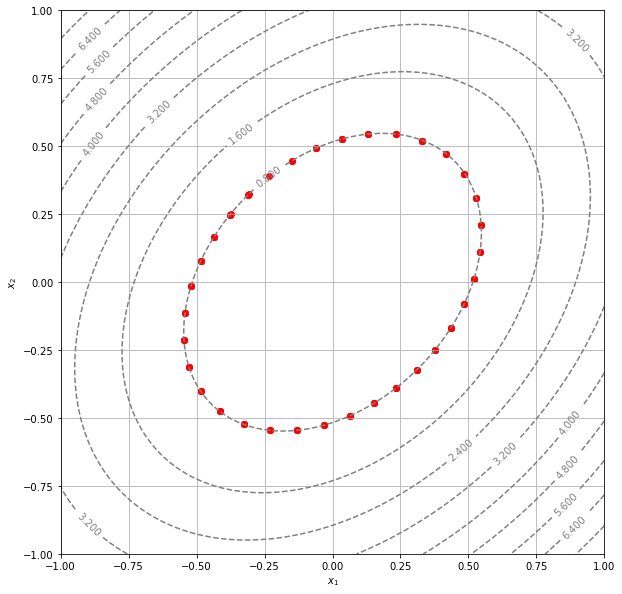

In [40]:
# Pour la fonction f1 et oversampling = 3

X1 = level_curve3(f1, -0.375, 0.25, 3)[0]
Y1 = level_curve3(f1, -0.375, 0.25, 3)[1] 

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

plt.scatter(X1, Y1, c='red')
plt.show()

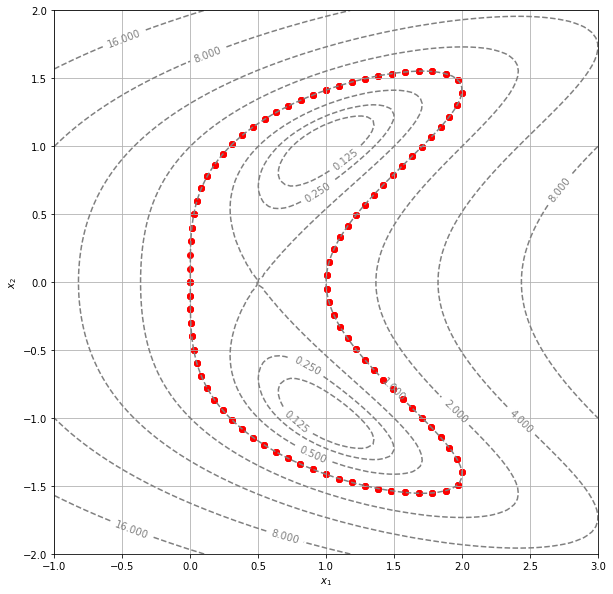

In [41]:
# avec la deuxième fonction et oversampling = 3

X2 = level_curve3(f2, 0, 0, 3)[0]
Y2 = level_curve3(f2, 0, 0, 3)[1] 

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

plt.scatter(X2, Y2, c='red')
plt.show()

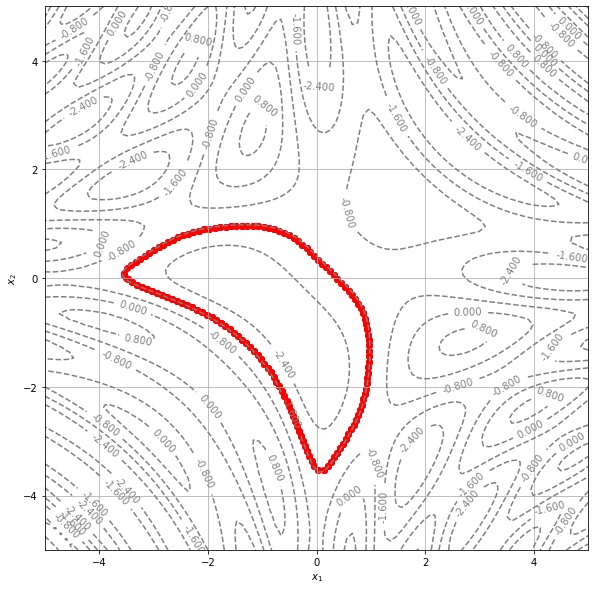

In [42]:
# avec la fonction f3

X4 = level_curve3(f3, -3.5, 0, 3)[0]
Y4 = level_curve3(f3, -3.5, 0, 3)[1]
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

plt.scatter(X4, Y4, c='red')
plt.show()

In [ ]:
# En revanche l'algorithme beugue toujours pour la courbe de niveau c = 0.5 ... 

X3 = level_curve3(f2, 1.5, 1, 3)[0]
Y3 = level_curve3(f2, 1.5, 1, 3)[1] 

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

plt.scatter(X3, Y3, c='orange')
plt.show()

In [ ]:
# avec la courbe de niveau c = 0.5 de la fonction f2

X1 = level_curve2(f2, 0.5, 0)[0] 
Y1 = level_curve2(f2, 0.5, 0)[1]

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

plt.scatter(X1, Y1, c='green')
plt.show()